# Homework 7
This homework is going to give you experience with LSTM models and additional insight into some of the tools stock traders use to predict when to buy and sell stocks.

Read the file SPY.csv which has the market data for the S&P 500 index fund.  Convert the 'Date' column to pandas datetime datetime and drop all the other columns except for "Adj Close".

Print the first 5 rows of the dataframe and then plot the Adjusted Close price vs date with a title and proper labels on the x-axis.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
from keras.src.callbacks.history import History

def plot_results(history: History):
    """
    Plots model loss vs epoch (for train and validation data).
    Also displays average train and validation loss.
    Args:
        history (Keras History Object): this is the Keras's History object returned when running model.fit()
    Returns:
        None 
    """
    plt.figure(figsize=(12, 5))

    # final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]


    # loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.text(0.09, 0.05, f'Train Loss: {final_train_loss:.4f}\nVal Loss: {final_val_loss:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

In [5]:
df = pd.read_csv('SPY-3.csv', parse_dates=['Date'])

df = df[['Date', 'Adj Close']]

df.set_index('Date', inplace=True)


print(df.head())

             Adj Close
Date                  
2023-03-13  379.590698
2023-03-14  385.865387
2023-03-15  383.452057
2023-03-16  390.179749
2023-03-17  385.617523


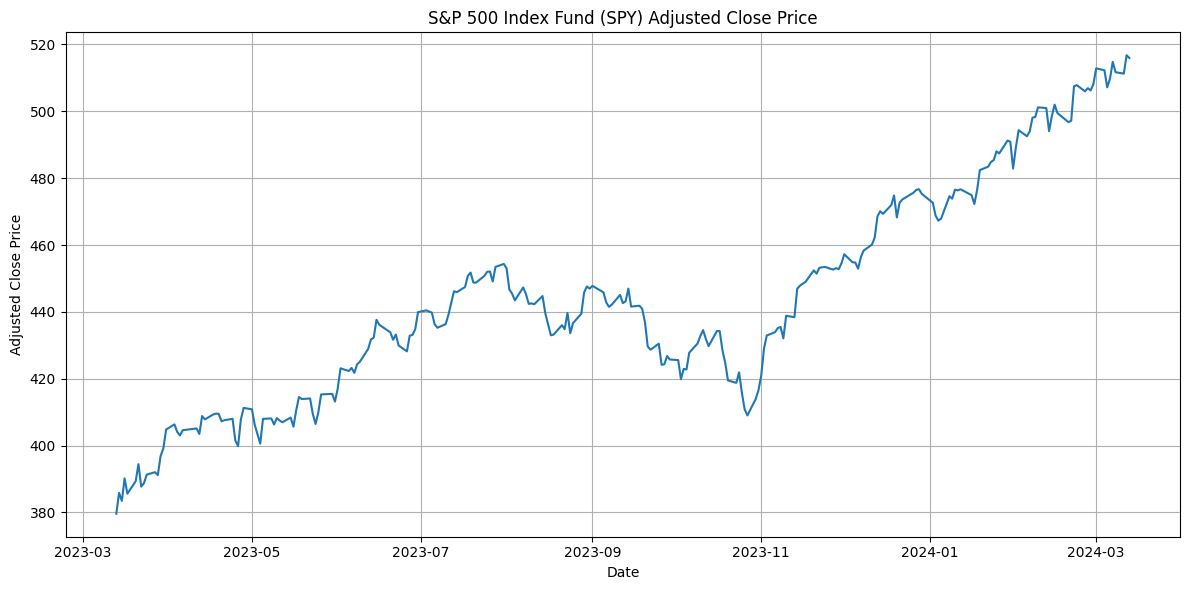

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df['Adj Close'])

plt.title('S&P 500 Index Fund (SPY) Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.tight_layout()

plt.show()

# Part a

Make the 'Date column into pandas datetime with .to_datetime() and make that column the index of the dataframe.  Plot the Adj Close price vs date.  Make sure the x-axis is labeled 'Date' and the year-month is labeling the tic marks.  Do not let the plot have numbers from zero to 365 for the x-axis.  Put a title on your plot as shown below:
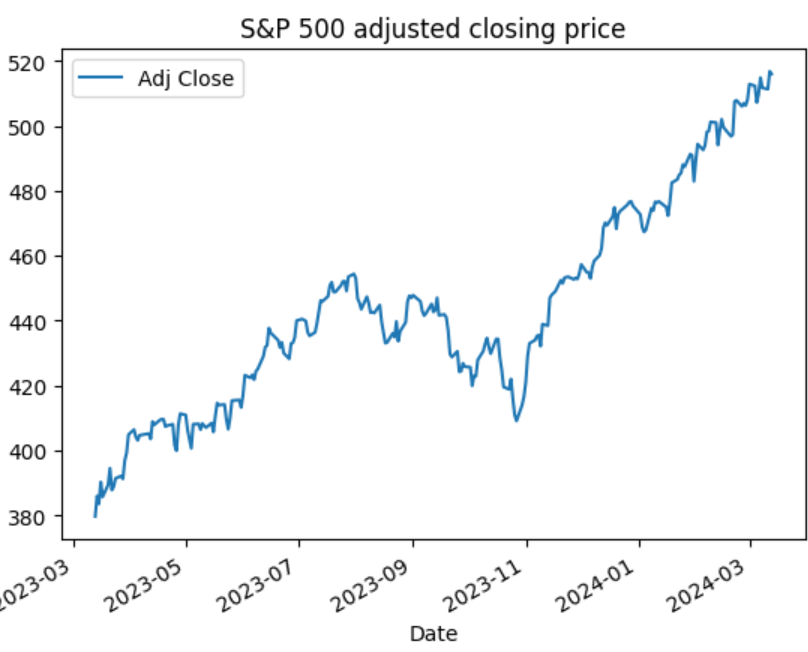

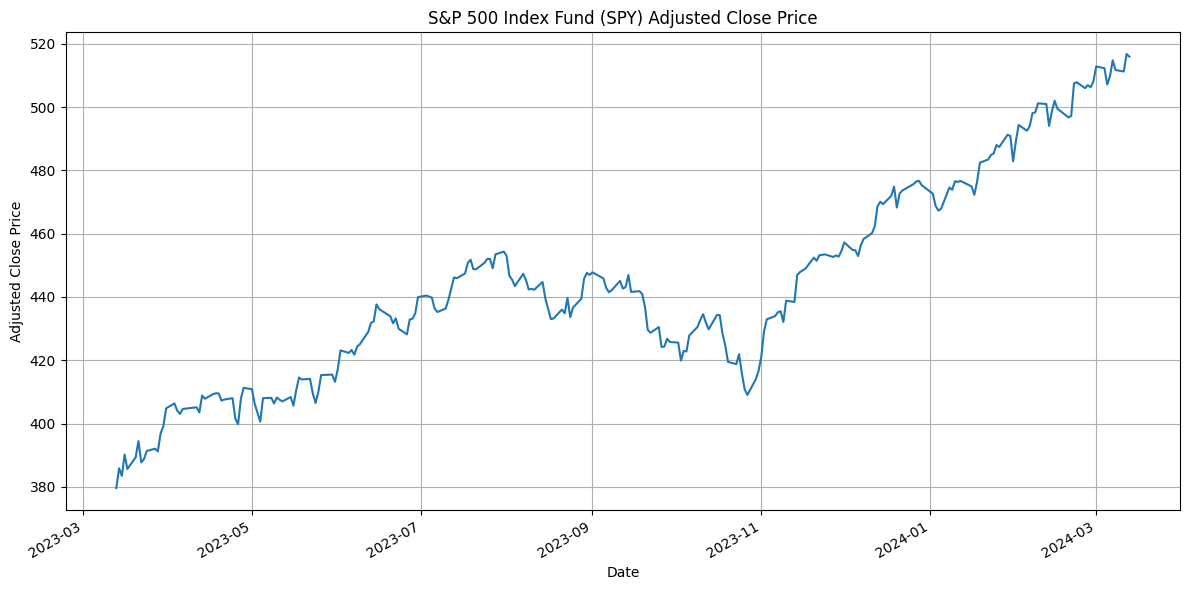

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df['Adj Close'])

ax.set_title('S&P 500 Index Fund (SPY) Adjusted Close Price')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price')


ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()


ax.grid(True)

plt.tight_layout()
plt.show()

# Part b
## Scale the data to range 0 to 1
Use the MinMaxScaler from sklearn to scale the adjusted closing price.
Plot the scaled closing price just to be sure the curve has the same shape.  Call the output of the scaler 'train'

Don't worry about the axis labels, just plot the numpy array.
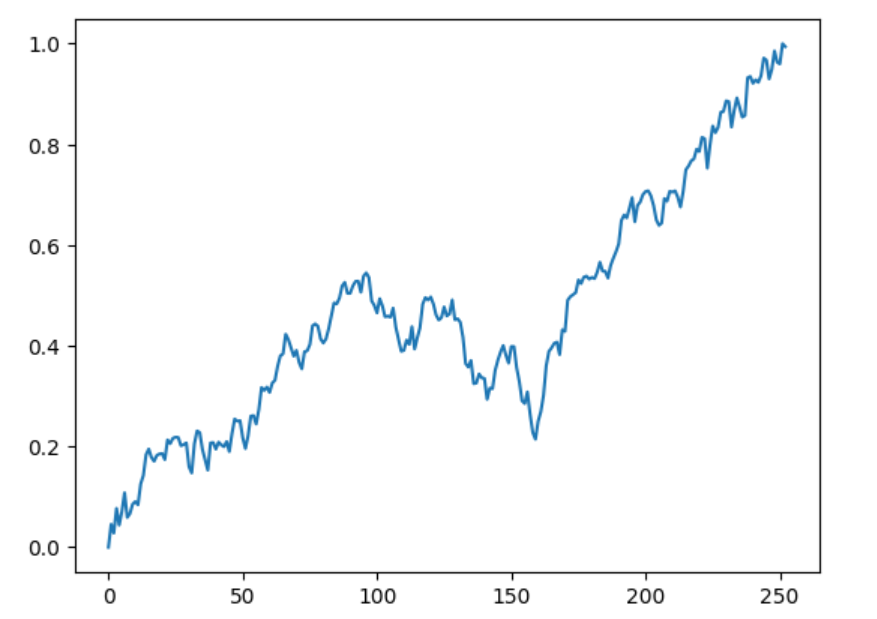

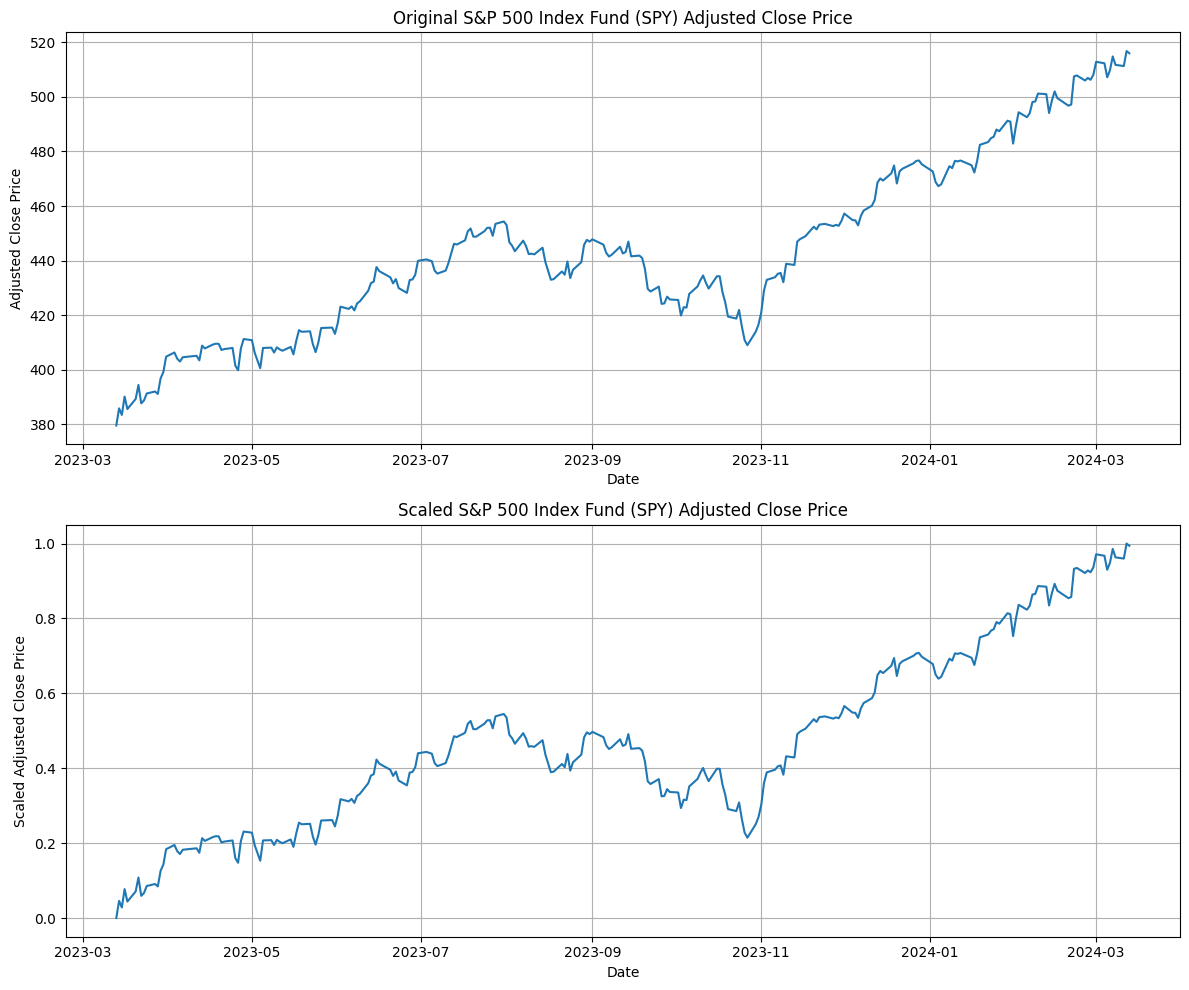

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(df[['Adj Close']])

df_scaled = pd.DataFrame(train, columns=['Scaled Adj Close'], index=df.index)

# plot the original and scaled data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# original data
ax1.plot(df.index, df['Adj Close'])
ax1.set_title('Original S&P 500 Index Fund (SPY) Adjusted Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close Price')
ax1.grid(True)

# scaled data
ax2.plot(df_scaled.index, df_scaled['Scaled Adj Close'])
ax2.set_title('Scaled S&P 500 Index Fund (SPY) Adjusted Close Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Adjusted Close Price')
ax2.grid(True)

plt.tight_layout()
plt.show()


## Incorporating Timesteps Into Data
We should input our data in the form of a 3D array to the LSTM model. First, we create data in 10 timesteps before using numpy to convert it into an array. Finally, we convert the data into a 3D array with X_train samples, 10 timestamps, and one feature at each step.

Each row of data has ten days of data.  Each successive row is the previous row, shifted by one day.

Use the following code to create your X_train and y_train arrays

In [9]:
X_train = []
y_train = []
for i in range(10, len(train)):
    X_train.append(train[i-10:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
X_train[:5]

array([[[0.        ],
        [0.04573744],
        [0.0281462 ],
        [0.07718567],
        [0.04393071],
        [0.07095867],
        [0.10822148],
        [0.05921049],
        [0.06685048],
        [0.08544563]],

       [[0.04573744],
        [0.0281462 ],
        [0.07718567],
        [0.04393071],
        [0.07095867],
        [0.10822148],
        [0.05921049],
        [0.06685048],
        [0.08544563],
        [0.09077928]],

       [[0.0281462 ],
        [0.07718567],
        [0.04393071],
        [0.07095867],
        [0.10822148],
        [0.05921049],
        [0.06685048],
        [0.08544563],
        [0.09077928],
        [0.08436475]],

       [[0.07718567],
        [0.04393071],
        [0.07095867],
        [0.10822148],
        [0.05921049],
        [0.06685048],
        [0.08544563],
        [0.09077928],
        [0.08436475],
        [0.1258076 ]],

       [[0.04393071],
        [0.07095867],
        [0.10822148],
        [0.05921049],
        [0.06685048],
  

# Part c
Using Keras Sequential, create an LSTM model that has the following:
LSTM layer with 50 units, return_sequences=True

Dropout layer with 0.2 dropout

LSTM layer with 50 units, return_sequences=True

Dropout layer with 0.2 dropout

LSTM layer with 50 units, return_sequences=True

Dropout layer with 0.2 dropout

LSTM layer with 50 units

Dropout layer with 0.2 dropout

Dense layer with one unit

Compile with 'adam' optimizer and loss='mean_squared_error' and fit with 100 epochs and batch_size 32.

The model summary should look like this:

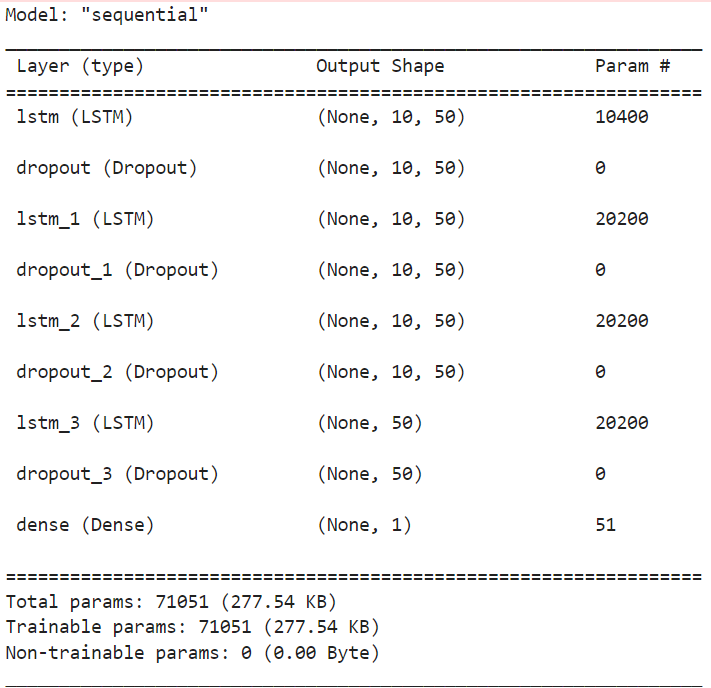

In [11]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

model.summary()


Epoch 1/100


/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.1500 - val_loss: 0.1780
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0264 - val_loss: 0.0316
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0165 - val_loss: 0.1575
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0180 - val_loss: 0.0362
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0130 - val_loss: 0.0359
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0087 - val_loss: 0.0497
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0014
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 7.9221e-04
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - val_loss: 0.00

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

### Plot the loss vs epochs for the model

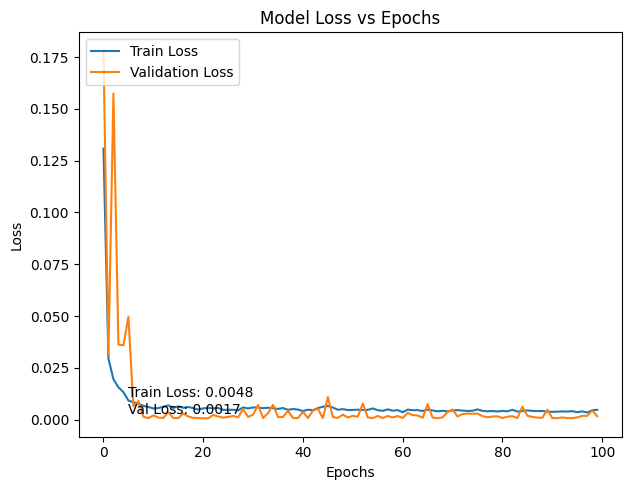

In [12]:
plot_results(history)

# Part d

Use model.predict to predict the stock price using X_train as input.  This will predict each day using the past ten days of X_train data in each row.  Then use the scaler inverse transform method to turn the predictions into the actual dollar amounts.

In [13]:
predictions = model.predict(X_train)

# reshape predictions to 2D array for inverse transform
predictions = predictions.reshape(-1, 1)

# inverse transform predictions --> $
predictions_actual = scaler.inverse_transform(predictions)

# inverse transform actual values (y_train) for comparison --> $
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

print("First 10 predictions (in dollars):")
print(predictions_actual[:10])
print("\nFirst 10 actual values (in dollars):")
print(y_train_actual[:10])

# MAE
mae = np.mean(np.abs(predictions_actual - y_train_actual))
print(f"\nMean Absolute Error: ${mae:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
First 10 predictions (in dollars):
[[397.4966 ]
 [398.40732]
 [398.90335]
 [399.5676 ]
 [399.97852]
 [400.91537]
 [401.95706]
 [403.0613 ]
 [404.76688]
 [406.43185]]

First 10 actual values (in dollars):
[[392.044647]
 [391.164642]
 [396.850159]
 [399.173828]
 [404.800049]
 [406.34256 ]
 [404.088104]
 [403.03009 ]
 [404.602264]
 [405.017517]]

Mean Absolute Error: $5.53


# Part e

Plot the predicted prices and the actual SPY prices on the same plot with labels, title, etc as shown below.
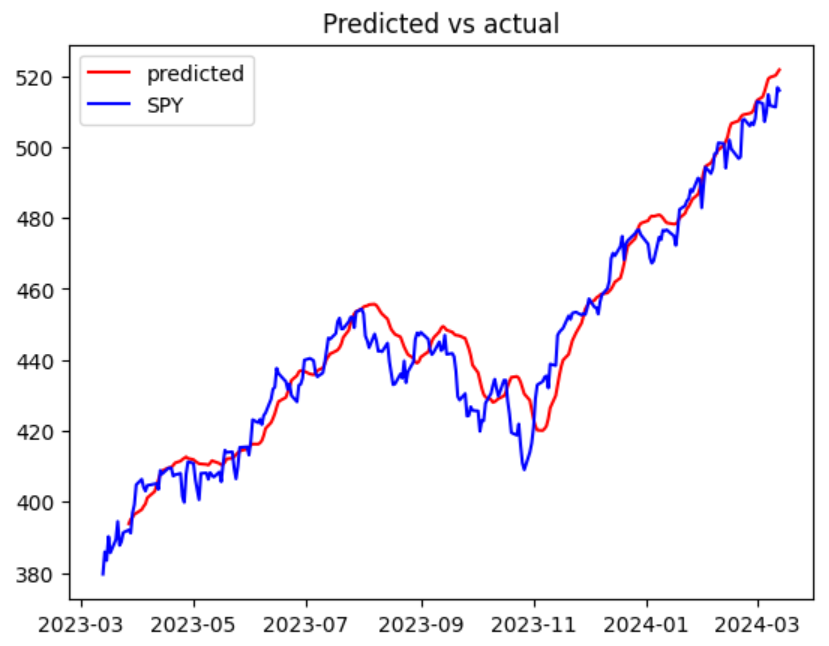

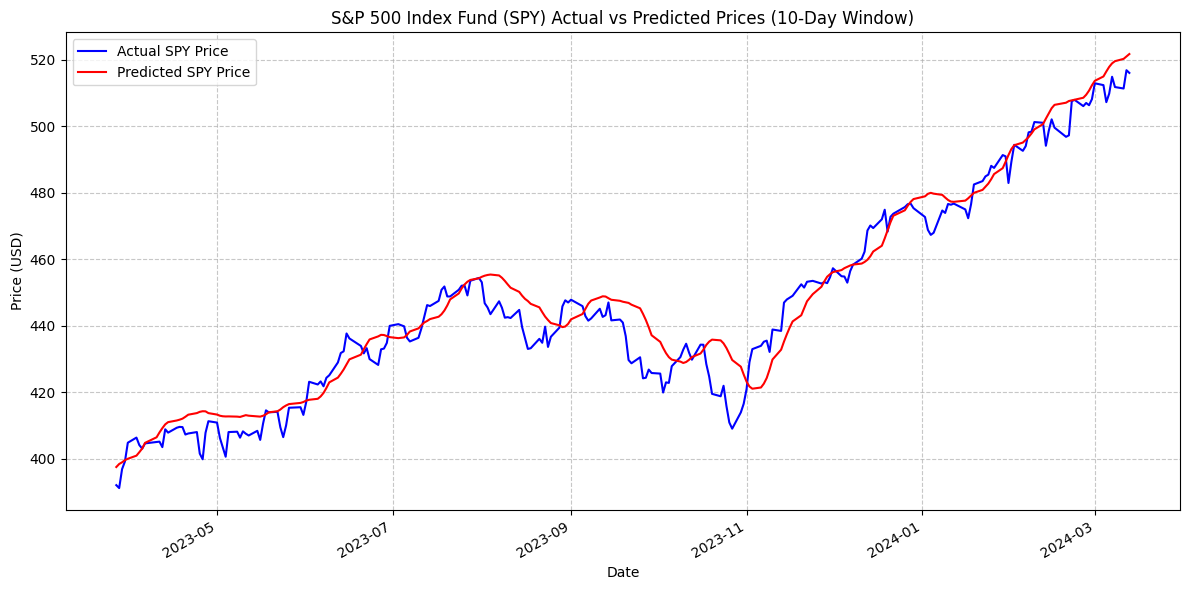

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

# actual prices (skip first 10 sinc first window has no predicted data)
ax.plot(df.index[10:], y_train_actual, label='Actual SPY Price', color='blue')

# predicted prices
ax.plot(df.index[10:], predictions_actual, label='Predicted SPY Price', color='red')

ax.set_title('S&P 500 Index Fund (SPY) Actual vs Predicted Prices (10-Day Window)')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')

ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# rotate and align the tick labels
fig.autofmt_xdate()

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Part f

## Now try again with a 30 day window.  Do the same code, but change it to a 30 day instead of 10 day window.  Use the same model configuration, compiler and fit.

In [15]:
# 30 day window
X_train = []
y_train = []
for i in range(30, len(train)):
    X_train.append(train[i-10:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)




Epoch 1/100


/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.2001 - val_loss: 0.3913
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0452 - val_loss: 8.5929e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0307 - val_loss: 0.1624
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0254 - val_loss: 0.1001
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0163 - val_loss: 0.0288
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0143 - val_loss: 0.0509
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124 - val_loss: 0.0212
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - val_loss: 0.0161
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058 - val_loss: 7.8379e-04
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 

## Plot the loss vs epochs for the model

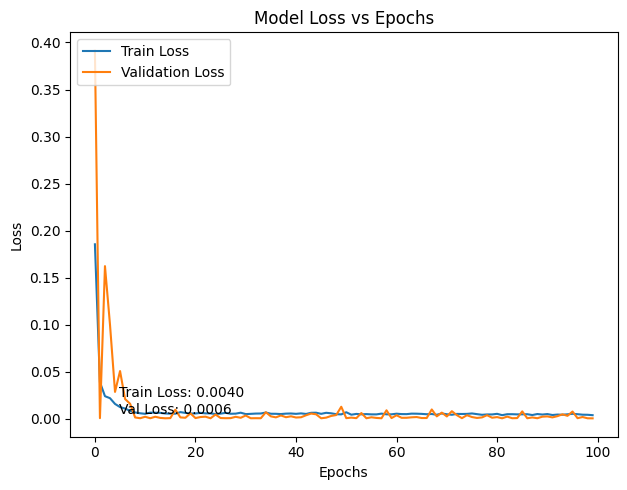

In [16]:
plot_results(history)

# Part g

Plot the same predicted and SPY as above using the 30 day window prediction.  Do you see a difference?

ANS: The large window has lower performance (lower MAE).

In [17]:
predictions = model.predict(X_train)

# reshape predictions to 2D array for inverse transform
predictions = predictions.reshape(-1, 1)

# inverse transform predictions --> $
predictions_actual = scaler.inverse_transform(predictions)

# inverse transform actual values (y_train) for comparison --> $
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

print("First 10 predictions (in dollars):")
print(predictions_actual[:10])
print("\nFirst 10 actual values (in dollars):")
print(y_train_actual[:10])

# MAE
mae = np.mean(np.abs(predictions_actual - y_train_actual))
print(f"\nMean Absolute Error: ${mae:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
First 10 predictions (in dollars):
[[414.9983 ]
 [415.24414]
 [415.38742]
 [414.95767]
 [414.59967]
 [414.23593]
 [413.98877]
 [413.8302 ]
 [413.81174]
 [413.72653]]

First 10 actual values (in dollars):
[[401.52713 ]
 [399.826385]
 [407.786163]
 [411.266693]
 [410.85141 ]
 [406.233765]
 [403.445343]
 [400.587769]
 [408.003693]
 [408.112457]]

Mean Absolute Error: $5.86


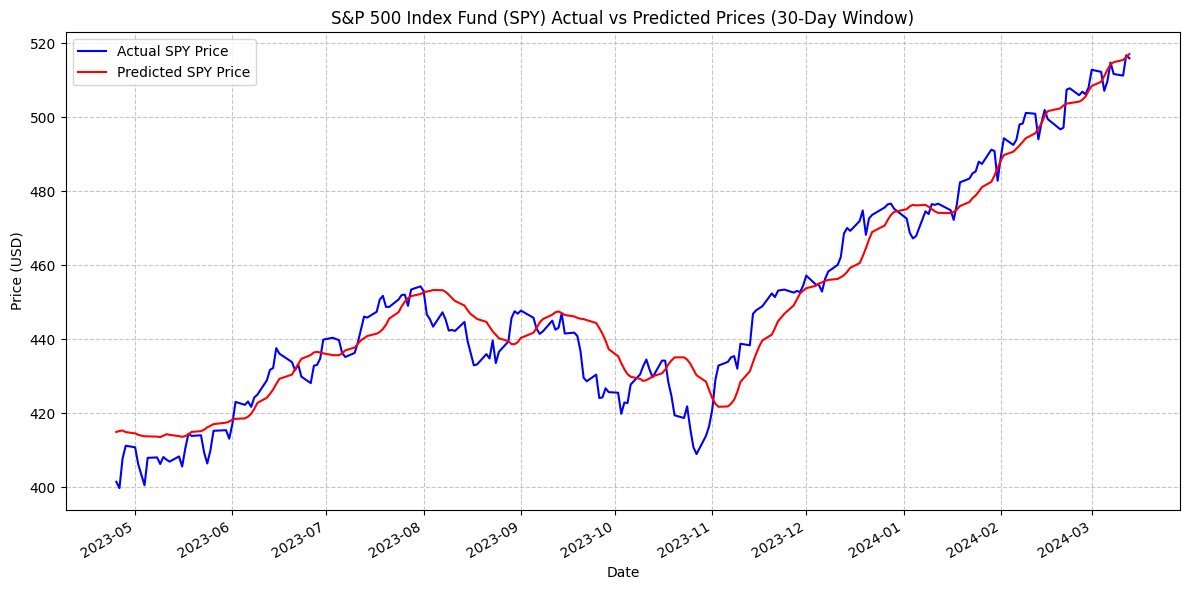

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

# actual prices
ax.plot(df.index[30:], y_train_actual, label='Actual SPY Price', color='blue')

# predicted prices
ax.plot(df.index[30:], predictions_actual, label='Predicted SPY Price', color='red')

ax.set_title('S&P 500 Index Fund (SPY) Actual vs Predicted Prices (30-Day Window)')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')

ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# rotate and align the tick labels
fig.autofmt_xdate()

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Part h

We are going to find all the anomaly days in the stock prices.  An anomaly day will be defined as a day where the mean squared error between the predicted value and actual value is more than three times the average daily mean squared error.

Using the predicted prices from the above 30 day model, calculate the mean squared error for each day and put it in the dataframe as 'mse_loss'.  You can fill the first thirty days with zeros since there is no prediction.  Plot a histogram of the mean squared error for each day and calculate the mean of all the daily mean squared error values (excluding the zeros you added for the first 30 days).

Next, make a column in the dataframe called 'anomaly'.  The value of 'anomaly' will be True if the daily mean squared error is greater than three times the average daily mean squared error.

Finally, plot the Adj Close for SPY with a blue line, the predicted values with a green line, and the anomaly days value with a red point.  Make sure you have a legened and the x-values are the date.  Think about what action you would take with your stock on the anomaly days.

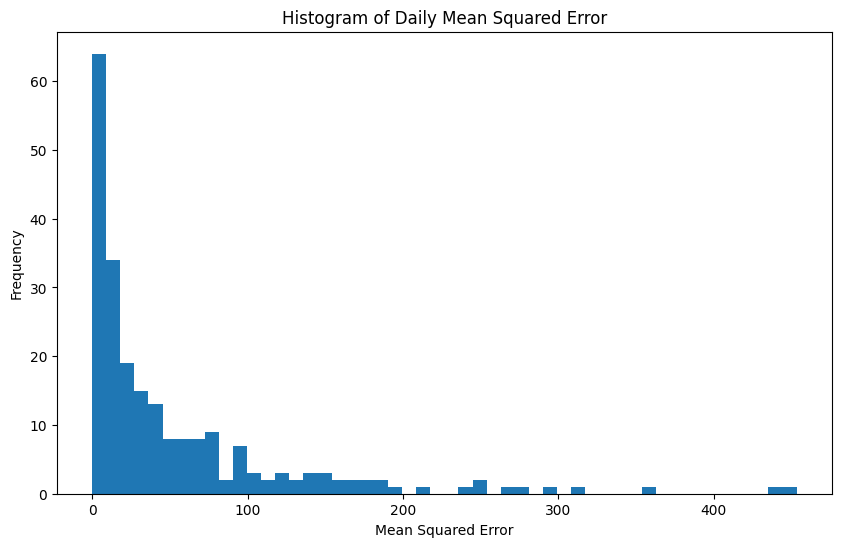

In [19]:
daily_mse = np.square(predictions_actual - y_train_actual).reshape(-1)

df_results = pd.DataFrame({
    'Date': df.index[30:], # remove 1st 30 days
    'Actual': y_train_actual.reshape(-1),
    'Predicted': predictions_actual.reshape(-1),
    'mse_loss': daily_mse
})

plt.figure(figsize=(10, 6))
plt.hist(df_results['mse_loss'], bins=50)
plt.title('Histogram of Daily Mean Squared Error')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.show()

In [20]:
# average daily MSE (excluding zeros)
avg_mse = df_results['mse_loss'].mean()
print(f"Average daily MSE: {avg_mse:.2f}")

# anomaly day flag
df_results['anomaly'] = df_results['mse_loss'] > 3 * avg_mse

df_results.head()

Average daily MSE: 53.51


,Date,Actual,Predicted,mse_loss,anomaly
0,2023-04-25,401.527130,414.998291,181.472179,True
1,2023-04-26,399.826385,415.244141,237.707189,True
2,2023-04-27,407.786163,415.387421,57.779118,False
3,2023-04-28,411.266693,414.957672,13.623327,False
4,2023-05-01,410.851410,414.599670,14.049456,False


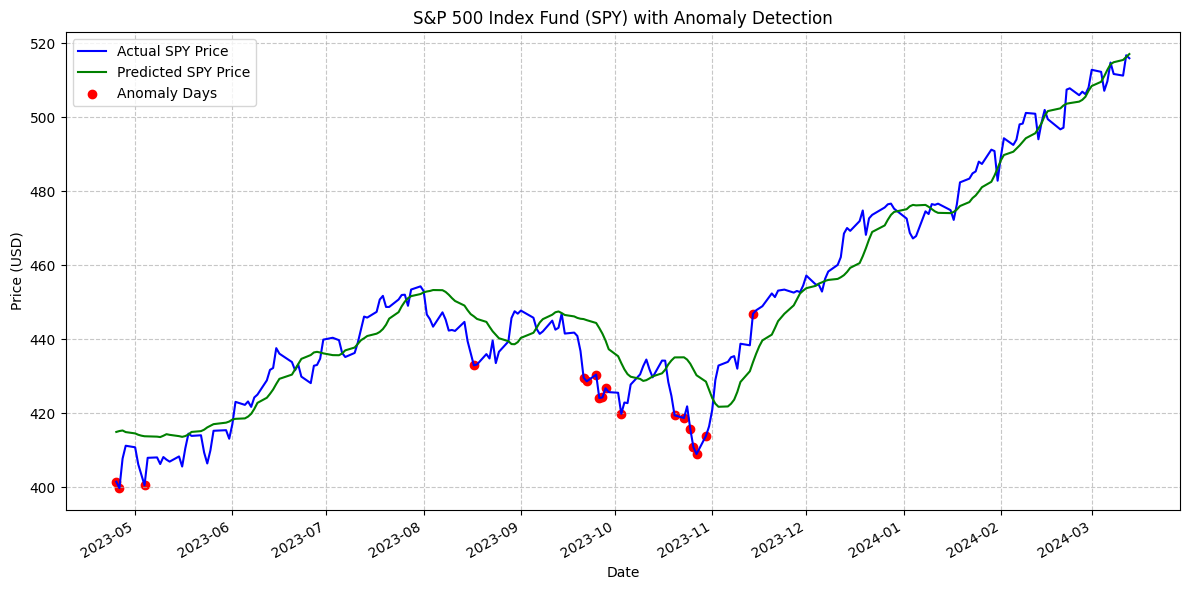

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

df_filtered= df[30:]

ax.plot(df_filtered.index, df_filtered['Adj Close'], color='blue', label='Actual SPY Price')
ax.plot(df_filtered.index, df_results['Predicted'], color='green', label='Predicted SPY Price')
ax.scatter(df_filtered.index[df_results['anomaly']], df_filtered['Adj Close'].values[df_results['anomaly']], color='red', label='Anomaly Days')

ax.set_title('S&P 500 Index Fund (SPY) with Anomaly Detection')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [22]:
print(f"Number of anomaly days: {df_results['anomaly'].sum()}")

Number of anomaly days: 18


# Part i

Stock traders often look at buying a stock when the current price is below the moving average.  The theory is that it will soon rise back up to the moving average.  Likewise, they sell when the price is above the moving average assuming it will fall back to the average.  You are going to print out 'buy' or 'sell' and the date when the stock price crosses the 30 day prediction prices we calculated above.

Now take the predicted price and add that as a column to the original dataframe with Adj Close and date.  You will have to cut the first 30 days from the original dataframe to make the lengths match.  Then add a column called 'above_below' that is 'Adj Close' minus 'predicted'.

In [23]:
df_pred = pd.DataFrame(predictions_actual, columns=['Predicted'], index=df.index[30:])


df_final = df[30:].join(df_pred)

# calculate 'above_below' column
df_final['above_below'] = df_final['Adj Close'] - df_final['Predicted']


def price_cross(row, prev_row):
    """
    In the POV of predicted prices: 

    If yesterday's price is predicted above adjusted close and
    today's price price is predicted below adjusted close, sell.

    If yesterday's price is predicted below adjusted close and
    today's price price is predicted above adjusted close, buy.

    So in essence, at a predicted 'maxima', sell and at a predicted 'minima' buy.
    """
    if prev_row['above_below'] < 0 and row['above_below'] > 0:
        return 'sell'
    elif prev_row['above_below'] > 0 and row['above_below'] < 0:
        return 'buy'
    else:
        return None

# save info into 'signa;s' list
signals = []
for i in range(1, len(df_final)):
    signal = price_cross(df_final.iloc[i], df_final.iloc[i-1])
    if signal:
        signals.append((df_final.index[i], signal))

print("Buy/Sell Signals:")
for date, signal in signals:
    print(f"{signal.capitalize()} on {date.strftime('%Y-%m-%d')}")


Buy/Sell Signals:
Sell on 2023-05-18
Buy on 2023-05-19
Sell on 2023-06-02
Buy on 2023-06-21
Sell on 2023-06-30
Buy on 2023-07-07
Sell on 2023-07-11
Buy on 2023-07-27
Sell on 2023-07-28
Buy on 2023-08-02
Sell on 2023-08-29
Buy on 2023-09-06
Sell on 2023-10-09
Buy on 2023-10-13
Sell on 2023-10-16
Buy on 2023-10-18
Sell on 2023-11-02
Buy on 2023-12-05
Sell on 2023-12-07
Buy on 2024-01-02
Sell on 2024-01-10
Buy on 2024-01-17
Sell on 2024-01-18
Buy on 2024-01-31
Sell on 2024-02-01
Buy on 2024-02-13
Sell on 2024-02-14
Buy on 2024-02-16
Sell on 2024-02-22
Buy on 2024-03-05
Sell on 2024-03-07
Buy on 2024-03-08
Sell on 2024-03-12
Buy on 2024-03-13


In [24]:
# sanity check
buy_signals = 0
sell_signals = 0
for action in signals:
    if action[1] == 'buy':
        buy_signals += 1
    else: 
        sell_signals += 1

print(f"\nTotal buy signals: {buy_signals}")
print(f"Total sell signals: {sell_signals}")


Total buy signals: 17
Total sell signals: 17


Create a new column that shows if the difference is positive (+1) and negative one if the difference is a negative number or zero.  Call that column 'diff'.  When you are done, the 'diff' column will only contain +1 or -1 values.

Now create a column called 'action'.  That will have 'sell' if 'diff' is one and 'buy' if diff is negative one.

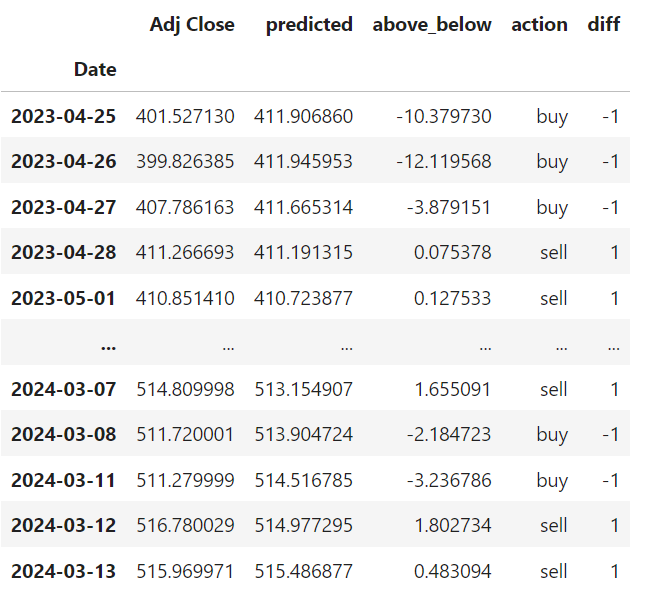

In [25]:
df_final['diff'] = np.where(df_final['above_below'] > 0, 1, -1)
df_final['action'] = np.where(df_final['diff'] == 1, 'sell', 'buy')

df_final.head()

,Adj Close,Predicted,above_below,diff,action
Date,,,,,
2023-04-25,401.527130,414.998291,-13.471161,-1,buy
2023-04-26,399.826385,415.244141,-15.417756,-1,buy
2023-04-27,407.786163,415.387421,-7.601258,-1,buy
2023-04-28,411.266693,414.957672,-3.690979,-1,buy
2023-05-01,410.851410,414.599670,-3.748260,-1,buy


# Part j

The pandas diff() method will show you the difference between the current row and the row above.  The line of code below will print the dataframe index values (which are now the Date) for each time the 'above_below' changes from +1 to -1 or from -1 to +1.

print(df['diff'].diff()[df['diff'].diff() != 0].index.values)

In [26]:
print(df_final['diff'].diff()[df_final['diff'].diff() != 0].index)

DatetimeIndex(['2023-04-25', '2023-05-18', '2023-05-19', '2023-06-02',
               '2023-06-21', '2023-06-30', '2023-07-07', '2023-07-11',
               '2023-07-27', '2023-07-28', '2023-08-02', '2023-08-29',
               '2023-09-06', '2023-10-09', '2023-10-13', '2023-10-16',
               '2023-10-18', '2023-11-02', '2023-12-05', '2023-12-07',
               '2024-01-02', '2024-01-10', '2024-01-17', '2024-01-18',
               '2024-01-31', '2024-02-01', '2024-02-13', '2024-02-14',
               '2024-02-16', '2024-02-22', '2024-03-05', '2024-03-07',
               '2024-03-08', '2024-03-12', '2024-03-13'],
              dtype='datetime64[ns]', name='Date', freq=None)


Now use those date indexes to print the dates where the predicted moves below the current price (in this case print 'buy').  When the predicted price goes above the current price, then print the date and 'sell'.  

In [27]:
# find crossover points
crossover_dates = df_final['diff'].diff()[df_final['diff'].diff() != 0].index

# print buy/sell signals
print("Buy/Sell Signals:")
for i, date in enumerate(crossover_dates):
    if i == 0:
        # for the first crossover, check the sign of 'above_below'
        action = 'sell' if df_final.loc[date, 'above_below'] > 0 else 'buy'
    else:
        # for subsequent crossovers, alternate between buy and sell
        action = 'buy' if df_final.loc[crossover_dates[i-1], 'above_below'] > 0 else 'sell'
    
    print(f"{action.capitalize()} on {date.strftime('%Y-%m-%d')}")

Buy/Sell Signals:
Buy on 2023-04-25
Sell on 2023-05-18
Buy on 2023-05-19
Sell on 2023-06-02
Buy on 2023-06-21
Sell on 2023-06-30
Buy on 2023-07-07
Sell on 2023-07-11
Buy on 2023-07-27
Sell on 2023-07-28
Buy on 2023-08-02
Sell on 2023-08-29
Buy on 2023-09-06
Sell on 2023-10-09
Buy on 2023-10-13
Sell on 2023-10-16
Buy on 2023-10-18
Sell on 2023-11-02
Buy on 2023-12-05
Sell on 2023-12-07
Buy on 2024-01-02
Sell on 2024-01-10
Buy on 2024-01-17
Sell on 2024-01-18
Buy on 2024-01-31
Sell on 2024-02-01
Buy on 2024-02-13
Sell on 2024-02-14
Buy on 2024-02-16
Sell on 2024-02-22
Buy on 2024-03-05
Sell on 2024-03-07
Buy on 2024-03-08
Sell on 2024-03-12
Buy on 2024-03-13


In [ ]:
# sanity check
buy_signals = sum(1 for i, date in enumerate(crossover_dates) if 
                  (i == 0 and df_final.loc[date, 'above_below'] <= 0) or 
                  (i > 0 and df_final.loc[crossover_dates[i-1], 'above_below'] > 0))
sell_signals = len(crossover_dates) - buy_signals

print(f"\nTotal buy signals: {buy_signals}")
print(f"Total sell signals: {sell_signals}")



Total buy signals: 18
Total sell signals: 17
